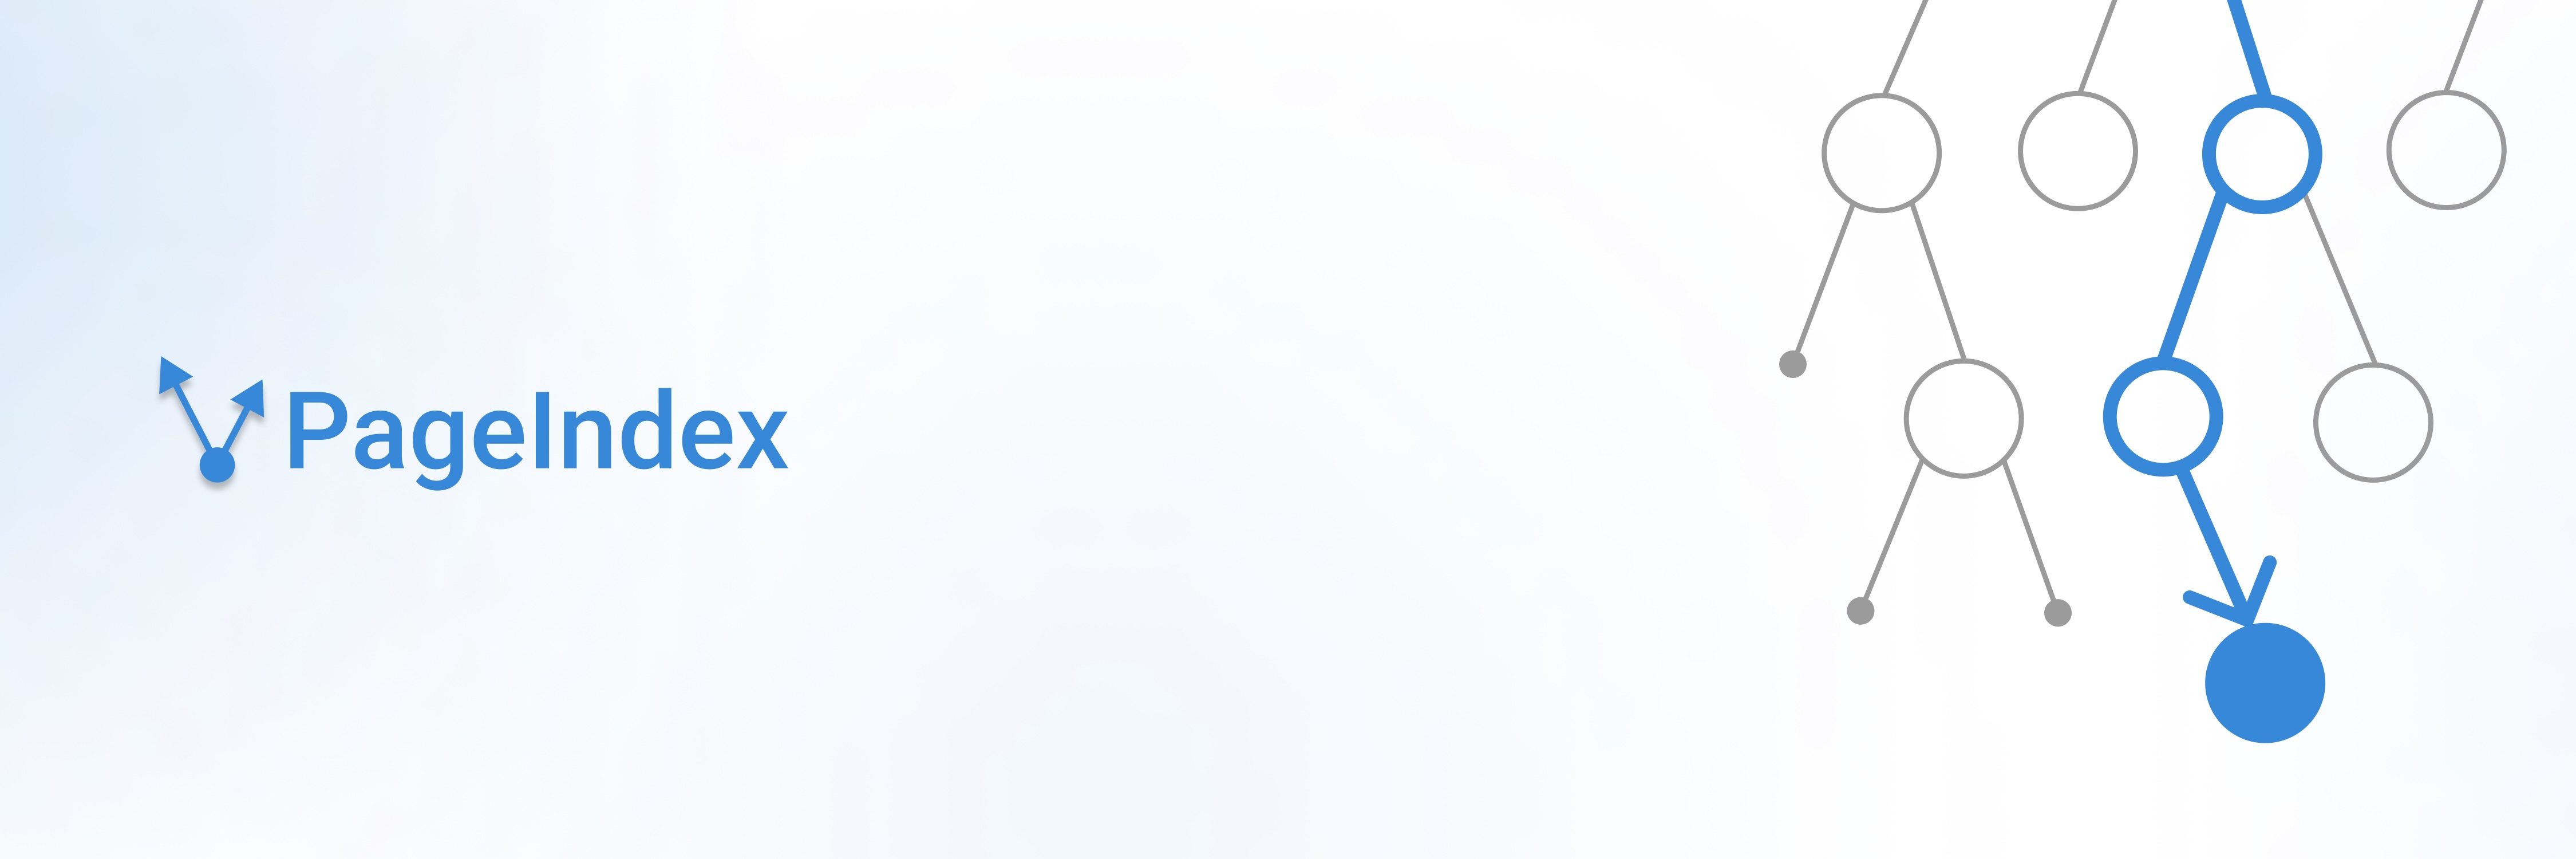

  <p align="center"><i>Reasoning-based RAG&nbsp; ✧ &nbsp;No Vector DB&nbsp; ✧ &nbsp;No Chunking&nbsp; ✧ &nbsp;Human-like Retrieval</i></p>

<p align="center">
  <a href="https://vectify.ai">🏠 Homepage</a>&nbsp; • &nbsp;
  <a href="https://dash.pageindex.ai">🖥️ Dashboard</a>&nbsp; • &nbsp;
  <a href="https://docs.pageindex.ai/quickstart">📚 API Docs</a>&nbsp; • &nbsp;
  <a href="https://github.com/vectifyai/pageindex">📦 GitHub</a>&nbsp; • &nbsp;
  <a href="https://discord.com/invite/VuXuf29EUj">💬 Discord</a>&nbsp; • &nbsp;
  <a href="https://ii2abc2jejf.typeform.com/to/tK3AXl8T">✉️ Contact</a>&nbsp;
</p>

# 🧠 Simple Vectorless RAG with PageIndex

PageIndex generates a searchable tree structure of documents, enabling reasoning-based retrieval through tree search — without vectors.

- **No Vectors Needed**: Uses document structure and LLM reasoning for retrieval.
- **No Chunking Needed**: Documents are organized into natural sections rather than artificial chunks.
- **No Top-K Needed**: The LLM decides how many nodes need to be retrieved.
- **Transparent Retrieval Process**: Retrieval based on reasoning — say goodbye to approximate semantic search ('vibe retrieval').

# 📝  About this Notebook
This notebook demonstrates a simple example of **vectorless RAG** with PageIndex. You will learn:
- [x] How to generate PageIndex tree structure of a document.
- [x] How to perform retrieval with tree search.
- [x] How to generate the answer based on the retrieved context.

# Preparation



## Install Dependencies

In [ ]:
%pip install -q --upgrade pageindex openai

## Setup Environment

In [ ]:
import os, json, openai, requests
from pageindex import PageIndexClient
from pprint import pprint
from IPython.display import Markdown, display

PAGEINDEX_API_KEY = "YOUR_PAGEINDEX_API_KEY"  # Get your PageIndex API key from https://dash.pageindex.ai/api-keys
OPENAI_API_KEY = "YOUR_OPENAI_API_KEY"

pi_client = PageIndexClient(api_key=PAGEINDEX_API_KEY)

## Define Utility Functions

In [137]:
async def call_llm(prompt, model="gpt-4.1", temperature=0):
    client = openai.AsyncOpenAI(api_key=OPENAI_API_KEY)
    response = await client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature
    )
    return response.choices[0].message.content.strip()

def remove_fields(data, fields=['text'], max_len=50):
    if isinstance(data, dict):
        return {k: remove_fields(v, fields)
            for k, v in data.items() if k not in fields}
    elif isinstance(data, list):
        return [remove_fields(item, fields) for item in data]
    elif isinstance(data, str):
        return (data[:max_len] + '...') if len(data) > max_len else data
    return data

def print_tree(tree, exclude_fields=['text', 'page_index']):
    cleaned_tree = remove_fields(tree.copy(), exclude_fields)
    pprint(cleaned_tree, sort_dicts=False, width=150)

def print_markdown(*lines):
    text = "\n".join(lines)
    display(Markdown(text))

def create_node_mapping(tree):
    """Create a mapping of node_id to node for quick lookup"""
    def get_all_nodes(tree):
        if isinstance(tree, dict):
            return [tree] + [node for child in tree.get('nodes', []) for node in get_all_nodes(child)]
        elif isinstance(tree, list):
            return [node for item in tree for node in get_all_nodes(item)]
        return []
    return {node["node_id"]: node for node in get_all_nodes(tree) if node.get("node_id")}

# Step 1: PageIndex Tree Generation

## Submit a document with PageIndex SDK

In [ ]:
# You can also use our GitHub repo to generate PageIndex structure
# https://github.com/VectifyAI/PageIndex

pdf_url = "https://arxiv.org/pdf/2501.12948.pdf"
pdf_path = os.path.join("../data", pdf_url.split('/')[-1])
os.makedirs(os.path.dirname(pdf_path), exist_ok=True)

response = requests.get(pdf_url)
with open(pdf_path, "wb") as f:
    f.write(response.content)
print(f"Downloaded {pdf_url}")

doc_id = pi_client.submit_document(pdf_path)["doc_id"]
print('Document Submitted:', doc_id)

Downloaded https://arxiv.org/pdf/2501.12948.pdf
Document Submitted: pi-cmek7luf400960ao3o0o8us4d


## Get the generated PageIndex tree structure

In [138]:
if pi_client.is_retrieval_ready(doc_id):
    tree = pi_client.get_tree(doc_id, node_summary=True)['result']
    print_markdown('## Simplified Tree Structure of the Document', '---')
    print_tree(tree)
else:
    print("Processing document, please try again later...")

## Simplified Tree Structure of the Document
---

[{'title': 'DeepSeek-R1: Incentivizing Reasoning Capability in...',
  'node_id': '0000',
  'prefix_summary': '# DeepSeek-R1: Incentivizing Reasoning Capability ...',
  'nodes': [{'title': 'Abstract', 'node_id': '0001', 'summary': 'The partial document introduces two reasoning mode...'},
            {'title': 'Contents', 'node_id': '0002', 'summary': 'This partial document provides a detailed table of...'},
            {'title': '1. Introduction',
             'node_id': '0003',
             'prefix_summary': 'The partial document introduces recent advancement...',
             'nodes': [{'title': '1.1. Contributions', 'node_id': '0004', 'summary': 'This partial document outlines the main contributi...'},
                       {'title': '1.2. Summary of Evaluation Results',
                        'node_id': '0005',
                        'summary': 'The partial document provides a summary of evaluat...'}]},
            {'title': '2. Approach',
             'node_id': '0006',
        

# Step 2: Reasoning-Based Retrieval with Tree Search

#### Use LLM to search the PageIndex tree and decide which nodes may contain the relevant context.

In [ ]:
query = "What are the conclusions in this document?"

tree_without_text = remove_fields(tree.copy(), fields=['text'])

search_prompt = f"""
You are given a question and a tree structure of a document.
Each node contains a node id, node title, and a corresponding summary.
Your task is to find all nodes that are likely to contain the answer to the question.

Question: {query}

Document tree structure:
{json.dumps(tree_without_text, indent=2)}

Please reply in the following JSON format:
{{
    "thinking": "<Your thinking process on which nodes are relevant to the question>",
    "node_list": ["node_id_1", "node_id_2", ..., "node_id_n"]
}}
Directly return the final JSON structure. Do not output anything else.
"""

tree_search_result = await call_llm(search_prompt)

In [ ]:
### Print retrieval nodes

node_map = create_node_mapping(tree)
tree_search_result_json = json.loads(tree_search_result)

print_markdown('## Reasoning Process', '---')
print_markdown(tree_search_result_json['thinking'])

print_markdown('## Retrieved Nodes', '---')
for node_id in tree_search_result_json["node_list"]:
    node = node_map[node_id]
    print(f"Node ID: {node['node_id']}\t Page: {node['page_index']}\t Title: {node['title']}")

## Reasoning Process
---

The question asks for the conclusions in the document. The most direct and relevant node is '5. Conclusion, Limitations, and Future Work' (node_id: 0019), as it explicitly contains the conclusion section. Additionally, the 'Abstract' (node_id: 0001) often summarizes the main findings and conclusions, and the 'Discussion' (node_id: 0018) may also contain concluding remarks or synthesis of results. However, the primary and most comprehensive source for conclusions is node 0019.

## Retrieved Nodes
---

Node ID: 0019	 Page: 16	 Title: 5. Conclusion, Limitations, and Future Work


# Step 3: Answer Generation

#### Extract context from relevant nodes and generate the final answer.

In [ ]:
# Prepare Retrieved Context

node_list = json.loads(tree_search_result)["node_list"]
relevant_content = "\n\n".join(node_map[node_id]["text"] for node_id in node_list)
print_markdown('## Retrieved Context', '---')
print_markdown(f'{relevant_content[:1000]} ...')

## Retrieved Context
---

## 5. Conclusion, Limitations, and Future Work

In this work, we share our journey in enhancing model reasoning abilities through reinforcement learning. DeepSeek-R1-Zero represents a pure RL approach without relying on cold-start data, achieving strong performance across various tasks. DeepSeek-R1 is more powerful, leveraging cold-start data alongside iterative RL fine-tuning. Ultimately, DeepSeek-R1 achieves performance comparable to OpenAI-o1-1217 on a range of tasks.

We further explore distillation the reasoning capability to small dense models. We use DeepSeek-R1 as the teacher model to generate 800K training samples, and fine-tune several small dense models. The results are promising: DeepSeek-R1-Distill-Qwen-1.5B outperforms GPT-4o and Claude-3.5-Sonnet on math benchmarks with $28.9 \%$ on AIME and $83.9 \%$ on MATH. Other dense models also achieve impressive results, significantly outperforming other instructiontuned models based on the same underlying checkpoints.

In the fut ...

In [ ]:
# Generate Answer

answer_prompt = f"""
Answer the question based on the context:

Question: {query}
Context: {relevant_content}

Provide a clear, concise answer based only on the context provided.
"""

print_markdown('## Generated Answer', '---')
answer = await call_llm(answer_prompt)
print_markdown(answer)

## Generated Answer
---

**Conclusions in this document:**

- DeepSeek-R1-Zero, a pure reinforcement learning (RL) model without cold-start data, achieves strong performance across various tasks.
- DeepSeek-R1, which combines cold-start data with iterative RL fine-tuning, is even more powerful and achieves performance comparable to OpenAI-o1-1217 on a range of tasks.
- The reasoning capabilities of DeepSeek-R1 can be successfully distilled into smaller dense models, with DeepSeek-R1-Distill-Qwen-1.5B outperforming GPT-4o and Claude-3.5-Sonnet on math benchmarks.
- Other small dense models fine-tuned with DeepSeek-R1 data also significantly outperform other instruction-tuned models based on the same checkpoints.

# 🎯 What's Next

This notebook has demonstrated a basic example of **reasoning-based**, **vectorless** RAG with PageIndex. The workflow illustrates the core idea:
> *Generating a hierarchical tree structure from a document, reasoning over that tree structure, and extracting relevant context without relying on a vector database or top-k similarity search*.

While this notebook highlights a minimal workflow, the PageIndex framework is built to support **far more advanced** use cases. In upcoming tutorials, we will introduce:
* **Multi-node reasoning for complex query** — Scale tree search to handle queries that require context from multiple nodes.
* **Multi-document search** — Enable reasoning-based navigation across large document collections, extending beyond a single file.
* **Efficient Tree search** — Improve tree search efficiency for long documents with a large number of nodes.
* **Expert Knowledge Integration and Preference Alignment** — Incorporate user preferences or expert insights by adding knowledge directly into the LLM tree search, without the need for fine-tuning.

# 🔎 Learn More About PageIndex
  <a href="https://vectify.ai">🏠 Homepage</a>&nbsp; • &nbsp;
  <a href="https://dash.pageindex.ai">🖥️ Dashboard</a>&nbsp; • &nbsp;
  <a href="https://docs.pageindex.ai/quickstart">📚 API Docs</a>&nbsp; • &nbsp;
  <a href="https://github.com/vectifyai/pageindex">📦 GitHub</a>&nbsp; • &nbsp;
  <a href="https://discord.com/invite/VuXuf29EUj">💬 Discord</a>&nbsp; • &nbsp;
  <a href="https://ii2abc2jejf.typeform.com/to/tK3AXl8T">✉️ Contact</a>

<br>

© 2025 [Vectify AI](https://vectify.ai)

